In [8]:
import matplotlib.pyplot as plt
import corner

import pymultinest

#Imports
import numpy as np
from scipy import stats
from scipy.special import erf
import json
import os
import sys
import random

from math import log10, floor


### Top directory for the location of project files. MUST BE CHANGED TO RUN ON OTHER USERS!
topDirectory = ''

### Create samples if they do not exist; runs code from createSamples.py
if not os.path.exists(topDirectory + "Samples/pulsarSamples.npy"):
    print("Samples NOT found")
    sys.exit()
else:
    print("Samples found and loaded.")

### Load samples from files
pulsarMassSamples = np.load(topDirectory + 'Samples/pulsarSamples.npy')
companionMassSamples = np.load(topDirectory + 'Samples/companionSamples.npy')
totalMassSamples = np.load(topDirectory + 'Samples/totalSamples.npy')
bothMassSamples = np.load(topDirectory + 'Samples/bothSamples.npy')
ratioSamples = np.load(topDirectory + 'Samples/ratioSamples.npy')
chirpSamples = np.load(topDirectory + 'Samples/chirpSamples.npy')


bothCorrSamples = np.load(topDirectory + 'Samples/bothCorrSamples.npy')

### PDF functions
# Single Gaussian Functions
def evalSingleGaussian(theta, x):
    mu, sig = theta[0], theta[1]
    return stats.norm(mu, sig).pdf(x)

# Two Gaussian Functions
def evalTwoGaussian(theta, x):
    mu1, mu2, sig1, sig2, alpha = theta
    return alpha * stats.norm(mu1, sig1).pdf(x) + (1-alpha) * stats.norm(mu2, sig2).pdf(x)


# Uniform Functions
def evalUniform(theta, x):
    mMin, mMax = theta[0], theta[1]
    return stats.uniform(mMin, mMax-mMin).pdf(x)

def evalUniformLowerOnly(theta, x):
    mMin = theta[0]
    return stats.uniform(mMin, 1-mMin).pdf(x)


# Half Gaussian Functions
def evalHalfGaussian(theta, x):
    sigma = theta[0]
    
    #Calls erf from scipy
    normaliser = 1/(erf(0.3889/sigma))
    
    return np.piecewise(x, [(0.45 <= x) & (x <= 1)], [lambda x:normaliser * ((2**(1.0/2))/(sigma*(np.pi**(1.0/2))))*np.exp(-((x-1)/(sigma*2**(1.0/2)))**2), 0])
  
    
def evalTwoHalfGaussian(theta, x):
    sigma1, mu2, sigma2, alpha = theta[0], theta[1], theta[2], theta[3]
    
    normaliser1 = 1/(erf(0.3889/sigma1))
    normaliser2numerator = 2/(sigma2*(np.pi*2)**(1.0/2))
    normaliser2denominator = erf((1-mu2)/(sigma2*2**(1.0/2))) + erf((mu2-0.45)/(sigma2*2**(1.0/2)))
    
    #lambda x: alpha * normaliser1 * ((2**(1.0/2))/(sigma*(np.pi**(1.0/2))))*np.exp(-((x-1)/(sigma*2**(1.0/2)))**2) + (1-alpha)*(normaliser2numerator/normaliser2denominator)*np.exp(-((x-mu2)/(sigma2*2**(1.0/2)))**2)
    
    #Calls erf from scipy
    return np.piecewise(x, [(0.45 <= x) & (x <= 1)], [lambda x: alpha * normaliser1 * ((2**(1.0/2))/(sigma1*(np.pi**(1.0/2))))*np.exp(-((x-1)/(sigma1*2**(1.0/2)))**2) + (1-alpha)*(normaliser2numerator/normaliser2denominator)*np.exp(-((x-mu2)/(sigma2*2**(1.0/2)))**2), 0])
        

Samples found and loaded.


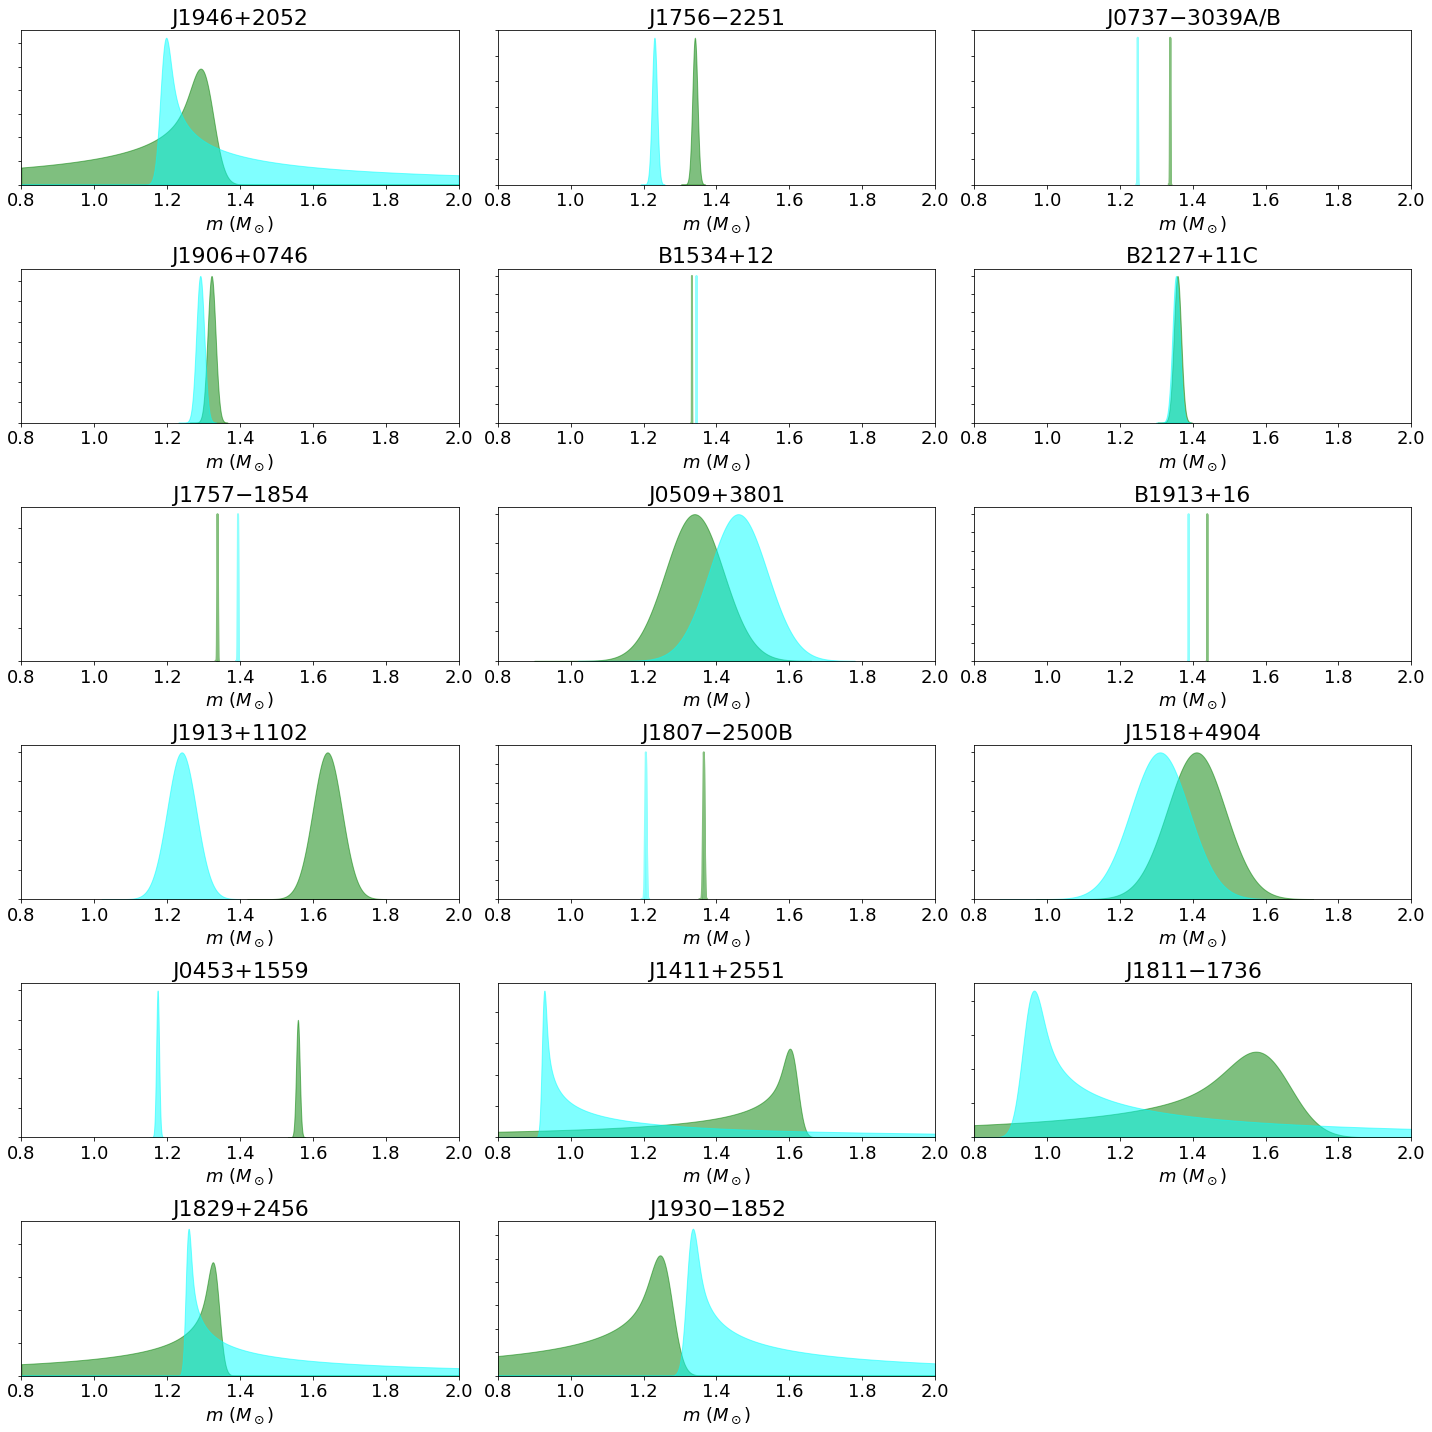

In [17]:
######################### NEW FIG 2 ##########################

pulsarPDFarray = np.transpose(np.loadtxt(topDirectory + 'Samples/pdfmr_0820_5p.txt'))
companionPDFarray = np.transpose(np.loadtxt(topDirectory + 'Samples/pdfms_0820_5p.txt'))
extraStarNames = [r"J1946+2052", r"J1411+2551", r"J1811$-$1736", r"J1829+2456", r"J1930$-$1852", ]

starOrder = [2, 0, 9, 4, 3, 6, 11, 5, 1, 8, 10, 7]

starnames = np.genfromtxt('PSR_BNSmass.txt', dtype='str')[:,0]
starNameList = [r'{}'.format(starname.replace('-','$-$')) for starname in starnames]

#plotRange = [1, 1.8]
plotRange = [0.8, 2]

starNameListOrdered = [starNameList[i] for i in starOrder]
pulsarMassOrdered = [pulsarMass[i] for i in starOrder]
pulsarUncertaintyOrdered = [pulsarUncertainty[i] for i in starOrder]
companionMassOrdered = [companionMass[i] for i in starOrder]
companionUncertaintyOrdered = [companionUncertainty[i] for i in starOrder]


plt.figure(num=None, figsize=(20, 20), facecolor='w', edgecolor='k')

masterOrder = [12, 2, 0, 9, 4, 3, 6, 11, 5, 1, 8, 10, 7, 15, 13, 16, 14]
weirdPDForder = [12, 15, 13, 16, 14]


##### NEW #####
for index, (pPDF, cPDF) in enumerate(zip(pulsarPDFarray, companionPDFarray)):
    starNumber = weirdPDForder[index]
    
    
    subplotIndex = masterOrder.index(starNumber)
    plt.subplot(6, 3, subplotIndex+1)

    
    xValues = np.linspace(0.8, 2, 1201).flatten()
    plt.fill_between(xValues, pPDF, color='green', alpha=0.5)
    plt.fill_between(xValues, cPDF, color='cyan', alpha=0.5)
    
    plt.xlabel(r"$m$ ($M_\odot$)", fontsize=18)
    #plt.ylabel(r"P($m_r,m_s$)", fontsize=18)
    plt.xlim(plotRange)
    plt.ylim(ymin=0)
    plt.tick_params(axis='x', labelsize=18)
    plt.title(extraStarNames[index], fontsize=22)
    plt.rc('ytick', labelsize=0)     
    
    frame1 = plt.gca()
    frame1.axes.yaxis.set_ticklabels([])
    
#plt.show()

############################ OLD ################

for index, ((mass1, unc1), (mass2, unc2)) in enumerate(zip(zip(pulsarMassOrdered, pulsarUncertaintyOrdered), zip(companionMassOrdered, companionUncertaintyOrdered))):
    
    starNumber = starOrder[index]
    
    subplotIndex = masterOrder.index(starNumber)
    plt.subplot(6, 3, subplotIndex+1)
    
    xValues1 = np.linspace(mass1-5.5*unc1, mass1+4*unc1, 5000)
    xValues2 = np.linspace(mass2-5.5*unc2, mass2+4*unc2, 5000)
    
    yValues1 = evalSingleGaussian([mass1, unc1], xValues1)
    yValues2 = evalSingleGaussian([mass2, unc2], xValues2)
    
#     plt.plot(xValues1, yValues1, linewidth=4, color='green', alpha=0.5)
#     plt.plot(xValues2, yValues2, linewidth=4, color='cyan', alpha=0.5)
    
    #plt.plot(xValues1, yValues1, color='green', linewidth=5)
    #plt.plot(xValues2, yValues2, color='cyan', linewidth=5)
    
    
    if index in [1, 3, 5, 7, 9]:
        plt.plot(xValues1, yValues1, color='#84BF7D', linewidth=2)
        plt.plot(xValues2, yValues2, color='#8FFFFE', linewidth=2)
    
    
    plt.fill_between(xValues1, yValues1, color='green', alpha=0.5)
    plt.fill_between(xValues2, yValues2, color='cyan', alpha=0.5)
    
#     plt.fill_between(xValues1, yValues1, color='green')
#     plt.fill_between(xValues2, yValues2, color='cyan')
    
    #plt.hist(pulsarSample, bins=binz, color='green', histtype="stepfilled", alpha=0.3, normed=True)
    #plt.hist(companionSample, bins=binz, color='cyan', histtype="stepfilled", alpha=0.3, normed=True)
    
    
    plt.xlabel(r"$m$ ($M_\odot$)", fontsize=18)
    #plt.ylabel(r"P($m_r,m_s$)", fontsize=18)
    plt.xlim(plotRange)
    plt.ylim(ymin=0)
    plt.tick_params(axis='x', labelsize=18)
    plt.rc('ytick', labelsize=0) 
    
    
    frame1 = plt.gca()
    frame1.axes.yaxis.set_ticklabels([])
    
    plt.title(starNameListOrdered[index], fontsize=22)
#plt.figlegend(["Pulsar Samples", "Companion Samples"], loc='upper center', bbox_to_anchor=(0.5, 0.325), prop={'size': 20})

plt.tight_layout()

#plt.suptitle('Pulsar Star Masses',fontsize=30)
plt.savefig("plotOutput/" + 'fig_pcSamples', dpi=200)

In [8]:
from scipy import integrate
integrate.quad(lambda x: evalTwoHalfGaussian([0.13, 0.5, 0.12, 0.2], x), 0.45, 1)

(1.0000000019671118, 1.7940241826375748e-11)

In [10]:
def loadData(filePath):
    #Loads text file into an array, excluding the name column.
    stringArray = np.genfromtxt(filePath, dtype='str')[:,1:]
    #Converts strings to floats
    floatArray = stringArray.astype(np.float)
    return floatArray

### Load core data (See Table 1 of paper).
coreData = loadData(topDirectory + 'PSR_BNSmass.txt')

### Load total mass data
totalData = loadData(topDirectory + 'BNSmtot.txt')

pulsarMass, pulsarUncertainty, companionMass, companionUncertainty = np.transpose(coreData[:,:4])
totalMass, totalUncertainty = np.transpose(totalData)

In [12]:


def cornerPlot(samples, bounds, parameterNames):
    plt.rcParams.update({'font.size': 15})
    return corner.corner(samples, bins=50, smooth=0.9, label_kwargs=dict(fontsize=16), show_titles=True, range=bounds, title_kwargs=dict(fontsize=16), color='#3fcca6', labels=parameterNames, plot_density=False, plot_datapoints=True, fill_contours=True, max_n_ticks=5)
    


def createPostConer(dataName, modelName, plotrange, parameterNames, save=False):
    
    prefix = 'out/' + dataName + '/' + modelName + '/'
    
    nDims = len(plotrange)
    a = pymultinest.analyse.Analyzer(nDims, outputfiles_basename=prefix)
    paramList=[]
    for params in a.get_equal_weighted_posterior():
            paramList.append(params)
    
    paramArray = np.asarray(paramList)
    
    round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1))
    
    for index, pName in enumerate(parameterNames):
        #print(np.shape(paramArray))
        
        paramPerc = np.percentile(paramArray[:,index],[5, 16, 50, 84, 95])
        roundedPercentiles = [str(round(number, 3)) for number in paramPerc]
        
        for index in range(len(roundedPercentiles)):
            number = roundedPercentiles[index]
            if len(number.split('.')[1]) < 3:
                roundedPercentiles[index] = number + '0'
            
        gapChar = " & "
        print("    & " + pName + " & " + gapChar.join(roundedPercentiles) + "\\"+ "\\")
    
    livePoints = paramArray
    cnr = cornerPlot(livePoints[:,:nDims], plotrange, parameterNames)
    
    
    if save == True:
        saveName = "plotOutput/" + dataName + 'Corner.png'
        cnr.savefig(saveName, dpi=200)
    

    
    return cnr

In [13]:
paramPerc = [0.1293]
roundedPercentiles = [str(round(number, 3)) for number in paramPerc]
        
for index in range(len(roundedPercentiles)):
    number = roundedPercentiles[index]
    if len(number.split('.')[1]) < 3:
        roundedPercentiles[index] = number + '0'

print(roundedPercentiles)
# round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1))
# round_to_n(0.1299, 3)

['0.129']


  analysing data from out/ratio/half/.txt
    & $\sigma$ & 0.086 & 0.098 & 0.122 & 0.157 & 0.193\\


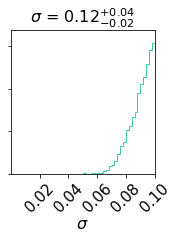

In [14]:
cnr = createPostConer('ratio', 'half', [(0.00, 0.1)], [r'$\sigma$'], save=False)

  analysing data from out/ratio/uniformRatio/.txt
    & a & 0.665 & 0.70 & 0.733 & 0.748 & 0.754\\


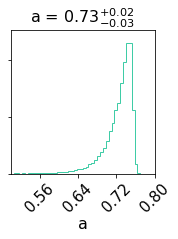

In [15]:
cnr = createPostConer('ratio', 'uniformRatio', [(0.5,0.8)], ['a'], save=False)

  analysing data from out/pulsar/twoGaussian/.txt
    & $\mu_{1}$ & 1.321 & 1.334 & 1.342 & 1.351 & 1.363\\
    & $\mu_{2}$ & 1.352 & 1.421 & 1.516 & 1.617 & 1.723\\
    & $\sigma_{1}$ & 0.007 & 0.010 & 0.016 & 0.035 & 0.184\\
    & $\sigma_{2}$ & 0.033 & 0.081 & 0.147 & 0.275 & 0.391\\
    & $\alpha$ & 0.331 & 0.486 & 0.670 & 0.810 & 0.881\\


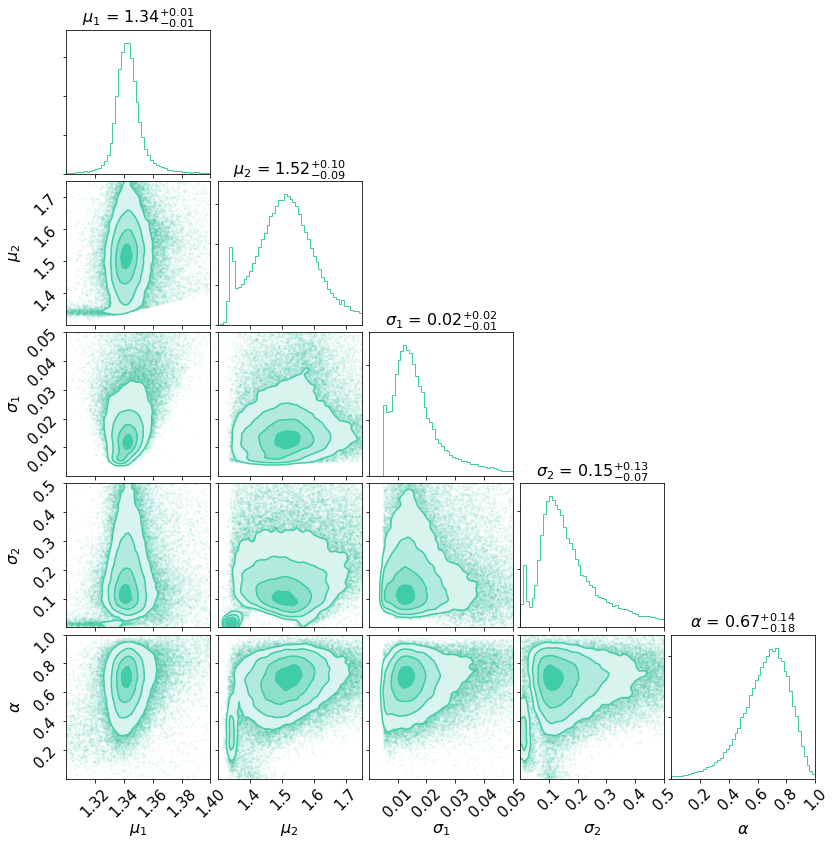

In [16]:
plotrange = [(1.3,1.4), (1.3,1.75), (0,0.05), (0,0.5), (0,1)]
cnr = createPostConer('pulsar', 'twoGaussian', plotrange, [r'$\mu_{1}$', r'$\mu_{2}$', r'$\sigma_{1}$', r'$\sigma_{2}$', r'$\alpha$'], save=True)

  analysing data from out/companion/uniform/.txt
    & $m_s^{l}$ & 1.094 & 1.128 & 1.158 & 1.171 & 1.175\\
    & $m_s^{u}$ & 1.396 & 1.401 & 1.420 & 1.462 & 1.505\\


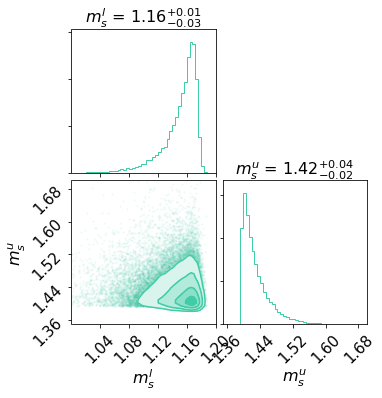

In [17]:
plotrange = [(1,1.2),(1.35,1.7)]
cnr = createPostConer('companion', 'uniform', plotrange, [r'$m_s^{l}$', r'$m_s^{u}$'], save=True)

  analysing data from out/total/uniform/.txt
    & $M_T^{l}$ & 2.430 & 2.466 & 2.506 & 2.535 & 2.550\\
    & $M_T^{u}$ & 2.855 & 2.865 & 2.885 & 2.916 & 2.948\\


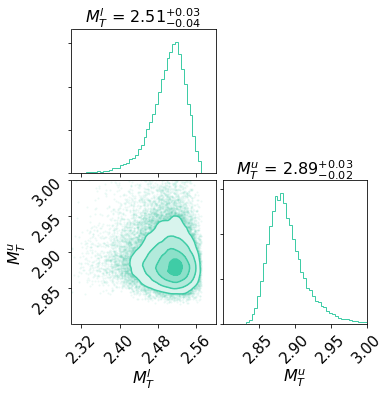

In [18]:
plotrange = [(2.3,2.6),(2.8,3)]
cnr = createPostConer('total', 'uniform', plotrange, [r'$M_T^{l}$', r'$M_T^{u}$'], save=True)

  analysing data from out/both/singleGaussian/.txt
    & $\mu$ & 1.311 & 1.326 & 1.348 & 1.371 & 1.386\\
    & $\sigma$ & 0.081 & 0.089 & 0.105 & 0.124 & 0.140\\


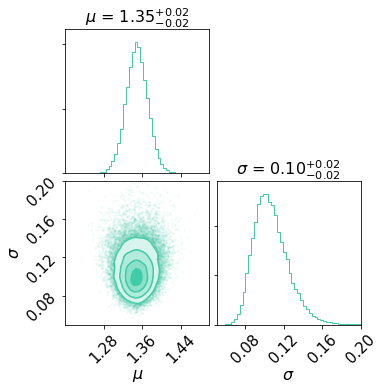

In [19]:
plotrange = [(1.2,1.5),(0.05,0.2)]
cnr = createPostConer('both', 'singleGaussian', plotrange, [r'$\mu$', r'$\sigma$'], save=True)

  analysing data from out/chirp/uniform/.txt
    & $\mathcal{M}_c^{l}$ & 1.076 & 1.094 & 1.109 & 1.115 & 1.116\\
    & $\mathcal{M}_c^{u}$ & 1.233 & 1.236 & 1.246 & 1.262 & 1.280\\


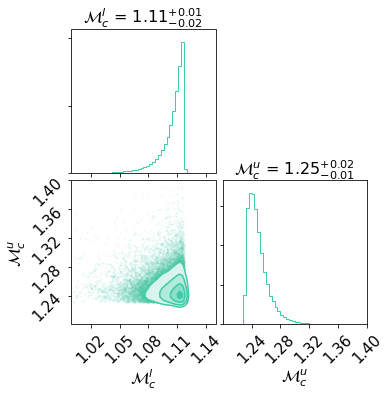

In [20]:
plotrange = [(1,1.15),(1.2,1.4)]
cnr = createPostConer('chirp', 'uniform', plotrange, [r'$\mathcal{M}_c^{l}$', r'$\mathcal{M}_c^{u}$'], save=True)

  analysing data from out/ratio/half/.txt
    & $\sigma$ & 0.086 & 0.098 & 0.122 & 0.157 & 0.193\\


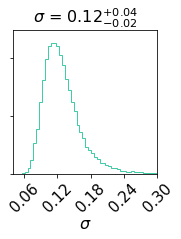

In [21]:
plotrange = [(0.04, 0.3)]
cnr = createPostConer('ratio', 'half', plotrange, [r'$\sigma$'], save=True)

  analysing data from out/ratio/uniformRatio/.txt
    & $q^{l}$ & 0.665 & 0.70 & 0.733 & 0.748 & 0.754\\


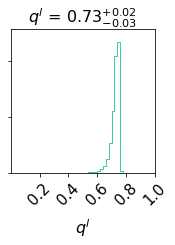

In [26]:
plotrange = [(0.0, 1)]
cnr = createPostConer('ratio', 'uniformRatio', plotrange, [r'$q^{l}$'], save=True)

In [ ]:
def createPredPostDist(dataName, modelName, evalFunction, plotrange, ndims, modelNum, drawNumber=1000, massSamples=[], showSampleLines=False, save=False):

    prefix = 'out/' + dataName + '/' + modelName + '/'
    
    nDims = ndims
    
    a = pymultinest.analyse.Analyzer(nDims, outputfiles_basename=prefix)
    
    paramList=[]
    for params in a.get_equal_weighted_posterior():
            paramList.append(params)
    
    paramArray = np.asarray(paramList)
    #print(np.shape(paramArray))
    
    paramsWithoutEvidence = paramArray[:,:-1].tolist()
    #print(np.shape(paramsWithoutEvidence))    
    

    drawnParams = [random.choice(paramsWithoutEvidence) for i in range(drawNumber)]
    
    xValues = np.linspace(plotrange[0], plotrange[1], 5000)    
    plt.xlim(plotrange[0], plotrange[1])
    
    
    yValueList = []
    for params in drawnParams:
        #print(params)
        yValues = evalFunction(params, xValues)
        yValueList.append(yValues)

        
    print(np.shape(np.asarray(yValueList)))
    
    yValueArray = np.asarray(yValueList)
    
    meanyValues = np.mean(yValueArray, axis=0)
    
#     if len(massSamples != 0):
#         weights = np.ones_like(massSamples.flatten())/float(len(massSamples.flatten()))
#         #plt.hist(massSamples.flatten(), bins=12, color='#3fcca6', histtype="stepfilled", alpha=0.3, weights=weights)
        
#         plt.hist(massSamples.flatten(), bins=40, color='#3fcca6', histtype="stepfilled", alpha=0.3, normed=True)
        
    if showSampleLines == True:
        for yValues in yValueList:
            plt.plot(xValues, yValues, alpha=0.1)

    
    if modelNum == 0:
        plt.plot(xValues, meanyValues, color='#3fcca6', linewidth=3)
    else:
        plt.plot(xValues, meanyValues, color='#3fcca6', alpha=0.3)
        #plt.plot(xValues, meanyValues, color='#3fcca6', alpha=0.3, scaley=False)
    
    if save == True:
        saveName = "plotOutput/" + dataName + 'Fit.png'
        plt.savefig(saveName, dpi=200)
    
    #plt.show()
    return meanyValues
    

In [ ]:
modelList = [['singleGaussian', evalSingleGaussian, 2], ['twoGaussian', evalTwoGaussian, 5], ['uniform', evalUniform, 2], ['uniformRatio', evalUniformLowerOnly, 1], ['half', evalHalfGaussian, 1]]

def createMultiPredPostdataName(dataName, modelList, plotrange, plotLabels=["M","P(M)"], binz=40, drawNumber=1000, massSamples=[], showSampleLines=False, save=False):
    plt.gcf().clear()
    #plt.gca()
    plt.rcParams.update({'font.size': 15})
    
    plt.gcf().subplots_adjust(bottom=0.15)
    
    plt.xlabel(plotLabels[0]); plt.ylabel(plotLabels[1])
    
    if len(massSamples != 0):
        plt.hist(massSamples.flatten(), bins=binz, color='#3fcca6', histtype="stepfilled", alpha=0.3, normed=True)
        
    
    for index, (modelName, evalFunction, modelDims) in enumerate(modelList):
        createPredPostDist(dataName, modelName, evalFunction, plotrange, modelDims, index, drawNumber, [], showSampleLines=False, save=False)
        
        
    if save == True:
        saveName = "plotOutput/" + dataName + 'Fit.png'
        plt.savefig(saveName, dpi=200)
    return plt

In [ ]:
pulsarModels = [modelList[i] for i in [1, 0, 2]]
createMultiPredPostdataName('pulsar', pulsarModels, [1.1, 1.8], [r'$m_r$ ($M_\odot$)',r'P($m_r$)'], 15, 2000, pulsarMassSamples, save=True)

In [ ]:
companionModels = [modelList[i] for i in [2, 0, 1]]
createMultiPredPostdataName('companion', companionModels, [1.0, 1.7], [r'$m_s$ ($M_\odot$)',r'P($m_s$)'], 15, 2000, companionMassSamples, save=True)

In [ ]:
totalModels = [modelList[i] for i in [2, 0, 1]]
createMultiPredPostdataName('total', totalModels, [2.3, 3], [r'$M_T$ ($M_\odot$)',r'P($M_T$)'], 12, 2000, totalMassSamples, save=True)

In [ ]:
bothModels = [modelList[i] for i in [0, 1, 2]]
createMultiPredPostdataName('both', bothModels, [1, 1.7], [r'$m$ ($M_\odot$)',r'P($m$)'], 15, 5000, bothMassSamples, save=True)

In [ ]:
chirpModels = [modelList[i] for i in [2, 0, 1]]
createMultiPredPostdataName('chirp', chirpModels, [1.05, 1.3], [r'$\mathcal{M}_c$ ($M_\odot$)',r'P($\mathcal{M}_c$)'], 8, 2000, chirpSamples, save=True)

In [ ]:
ratioModels = [modelList[i] for i in [4, 3]]
createMultiPredPostdataName('ratio', ratioModels, [0.45, 1], [r'$q$',r'P($q$)'], 15, 5000, ratioSamples, save=True)

In [ ]:
plt.figure(num=None, figsize=(20, 20), facecolor='w', edgecolor='k')

i = 0
plt.subplot(5, 5, i + 1)
pulsarModels = [modelList[i] for i in [1, 0, 2]]
createMultiPredPostdataName('pulsar', pulsarModels, [1.1, 1.8], [r'$m_r$ ($M_\odot$)',r'P($m_r$)'], 15, 1000, pulsarMassSamples, save=False)

i += 1
plt.subplot(5, 5, i + 1)
companionModels = [modelList[i] for i in [2, 0, 1]]
createMultiPredPostdataName('companion', companionModels, [1.0, 1.7], [r'$m_s$ ($M_\odot$)',r'P($m_s$)'], 15, 1000, companionMassSamples, save=False)

i += 1
plt.subplot(5, 5, i + 1)
totalModels = [modelList[i] for i in [2, 0, 1]]
createMultiPredPostdataName('total', totalModels, [2.3, 3], [r'$M_T$ ($M_\odot$)',r'P($M_T$)'], 12, 1000, totalMassSamples, save=False)

i += 1
plt.subplot(5, 5, i + 1)
chirpModels = [modelList[i] for i in [2, 0, 1]]
createMultiPredPostdataName('chirp', chirpModels, [1.05, 1.3], [r'$\mathcal{M}_c$ ($M_\odot$)',r'P($\mathcal{M}_c$)'], 8, 1000, chirpSamples, save=False)

i += 1
plt.subplot(5, 5, i + 1)
ratioModels = [modelList[i] for i in [4, 3]]
createMultiPredPostdataName('ratio', ratioModels, [0.45, 1], [r'$q$',r'P($q$)'], 15, 1000, ratioSamples, save=False)


plt.show()

In [ ]:
#createPredPostDist('pulsar', 'twoGaussian', evalTwoGaussian, [1.2, 1.8], 5, 5000, pulsarMassSamples, save=True)

In [ ]:
#createPredPostDist('companion', 'uniform', evalUniform, [1.1, 1.5], 2, 5000, companionMassSamples, save=True)

In [ ]:
#createPredPostDist('total', 'uniform', evalUniform, [2.35, 3], 2, 5000, totalMassSamples, save=True)

In [ ]:
#createPredPostDist('chirp', 'uniform', evalUniform, [1.05, 1.3], 2, 5000, chirpSamples, save=True)

In [ ]:
#createPredPostDist('ratio', 'half', evalHalfGaussian, [0.45, 1], 1, 5000, ratioSamples, save=True)

In [ ]:
from scipy import integrate
from scipy import optimize

# import warnings
# warnings.filterwarnings('error')


prefix = 'out/' + 'ratio' + '/' + 'half' + '/'

nDims = 1
    
a = pymultinest.analyse.Analyzer(nDims, outputfiles_basename=prefix)
    
paramList=[]
for params in a.get_equal_weighted_posterior():
    paramList.append(params)
    
paramArray = np.asarray(paramList)
#print(np.shape(paramArray))
    
paramsWithoutEvidence = paramArray[:,:-1].tolist()

drawnParams = [random.choice(paramsWithoutEvidence) for i in range(5000)]
#random.sample(paramsWithoutEvidence, 1000)
#print(len(paramsWithoutEvidence))


### Function which calculates integral of halfgaussian from 0.45 to upperLimit, returns area-percentile
#Turning this into a root finding problem, solving for which upperLimit the function returns zero.
def integralHalfPercRoot(upperLimit, sigma, percentile=0.01):
    #Integrate from 0.45 to upperLimit
    result = integrate.quad(lambda x: evalHalfGaussian(sigma, x), 0.45, upperLimit)
    
    #Returns the probability - percentile.
    return result[0] - percentile

#Create empty list of lower bounds
lowerBounds = []
lowerBounds2 = []

#For each sigma in the posterior
for index, sigma in enumerate(drawnParams):
    
    print(index, sigma)
    
    #Find the root of the integralHalfPercRoot function with a starting guess of 0.45
    lowerBound2 = optimize.fsolve(integralHalfPercRoot, 0.45, args=sigma)
    lowerBound = optimize.brentq(integralHalfPercRoot, 0.45, 1, args=sigma)
    
    #Add the lowerbound to the lower bound list.
    lowerBounds.append(lowerBound)
    lowerBounds2.append(lowerBound2)
    
#     if lowerBound > 0.8:
#         print(index, sigma, lowerBound)
    
    
    if index % 1000 == 0:
        print("{} done.".format(index))


In [ ]:
print(integralHalfPercRoot(0.58049468, [0.06580650180578232], percentile=0.005))
print(integralHalfPercRoot(0.815275, [0.06580650180578232], percentile=0.005))

optimize.brentq(integralHalfPercRoot, 0.45, 1, args=[0.06580650180578232])

#optimize.brentq(integralHalfPercRoot, 0.6, args=[0.06580650180578232])

In [ ]:
print(len(paramsWithoutEvidence))
sigmaList = np.asarray(paramsWithoutEvidence)
plt.hist(sigmaList.flatten(), bins=1000, color='#3fcca6', histtype="stepfilled", alpha=1, normed=True)
plt.xlim(0.04,0.1)
print(min(sigmaList))

In [ ]:
lowerBoundArray = np.asarray(lowerBounds)
plt.hist(lowerBoundArray.flatten(), bins=100, color='#3fcca6', histtype="stepfilled", alpha=1, normed=True)
#plt.xlim(0.75, 0.9)
plt.xlabel(r'$q_{\mathrm{0.01}}$')

In [ ]:
lowerBoundArray = np.asarray(lowerBounds2)
plt.hist(lowerBoundArray.flatten(), bins=100, color='#3fcca6', histtype="stepfilled", alpha=1, normed=True)
#plt.xlim(0.75, 0.9)
plt.xlabel(r'$q_{\mathrm{0.01}}$')

In [ ]:
lowerBoundArray = np.asarray(lowerBounds)
plt.hist(lowerBoundArray.flatten(), bins=50, color='#3fcca6', histtype="stepfilled", alpha=0.3, normed=True)
plt.xlabel(r'$q_{\mathrm{min}}$')
plt.show()
plt.hist(lowerBoundArray.flatten(), bins=100, color='#3fcca6', histtype="stepfilled", alpha=0.3, normed=True)
plt.xlabel(r'$q_{\mathrm{min}}$')
plt.savefig('ratio_lowerbound', dpi=200)
plt.show()
plt.hist(lowerBoundArray.flatten(), bins=200, color='#3fcca6', histtype="stepfilled", alpha=0.3, normed=True)
plt.xlabel(r'$q_{\mathrm{min}}$')
plt.show()
plt.hist(lowerBoundArray.flatten(), bins=400, color='#3fcca6', histtype="stepfilled", alpha=0.3, normed=True)
plt.xlabel(r'$q_{\mathrm{min}}$')
plt.show()


In [ ]:
print(lowerBounds[0])

integrate.quad(lambda x: evalHalfGaussian(lowerBounds[0][1], x), 0.45, 0.72066778)

In [ ]:
starOrder = [12, 2, 0, 9, 4, 3, 6, 11, 5, 1, 8, 10, 7, 15, 13, 16, 14]

plotRange = [2.2, 3]

starnames = np.genfromtxt('BNSmtot.txt', dtype='str')[:,0]
starNameList = [r'{}'.format(starname.replace('-','$-$')) for starname in starnames]
#print(starNameList)

starNamesListOrdered = [starNameList[i] for i in starOrder]


binz = np.arange(2.2, 3, 0.01)

plt.figure(num=None, figsize=(20, 20), facecolor='w', edgecolor='k')
for index, (mass, unc) in enumerate(zip(totalMass, totalUncertainty)):
    plt.subplot(6, 3, index + 1)
    
    xValues = np.linspace(plotRange[0], plotRange[1], 5000)
    yValues = evalSingleGaussian([mass, unc], xValues)
    
    #plt.plot(xValues, yValues, color='#3fcca6')
    
    plt.fill_between(xValues, yValues, color='#3fcca6', alpha=0.5)
    
    #plt.hist(sample, bins=binz, color='#3fcca6', histtype="stepfilled", alpha=0.3, normed=True)

    
    plt.xlabel(r"$M_T$ ($M_\odot$)", fontsize=18)
    plt.ylabel(r"P($M_T$)", fontsize=18)
    plt.xlim(plotRange)
    plt.ylim(ymin=0)
    plt.tick_params(axis='both', labelsize=18)

    plt.title(starNameList[index], fontsize=22)
#plt.figlegend(["Total Mass Samples"], loc='lower right', bbox_to_anchor=(0.95, 0.08), prop={'size': 20})

#plt.figlegend(["Total Mass Samples", "Companion Mass Samples"], loc='lower center', prop={'size': 20})

plt.tight_layout()   
#plt.suptitle('Pulsar Star Masses',fontsize=30)
plt.savefig('fig_tSamples', dpi=200)

In [ ]:
starnames = np.genfromtxt('PSR_BNSmass.txt', dtype='str')[:,0]
starNameList = [r'{}'.format(starname.replace('-','$-$')) for starname in starnames]

plotRange = [1.1, 1.75]

#print(binz)

#pulsPair = pulsarMass, pulsarUnc
#compPair = companionMass, companionUnc



plt.figure(num=None, figsize=(20, 20), facecolor='w', edgecolor='k')
for index, ((mass1, unc1), (mass2, unc2)) in enumerate(zip(zip(pulsarMass, pulsarUncertainty), zip(companionMass, companionUncertainty))):
    plt.subplot(6, 3, index + 1)
    
    xValues = np.linspace(plotRange[0], plotRange[1], 5000)
    yValues1 = evalSingleGaussian([mass1, unc1], xValues)
    yValues2 = evalSingleGaussian([mass2, unc2], xValues)
    
    plt.fill_between(xValues, yValues1, color='green', alpha=0.5)
    plt.fill_between(xValues, yValues2, color='cyan', alpha=0.5)
    
    #plt.hist(pulsarSample, bins=binz, color='green', histtype="stepfilled", alpha=0.3, normed=True)
    #plt.hist(companionSample, bins=binz, color='cyan', histtype="stepfilled", alpha=0.3, normed=True)
    
    
    plt.xlabel(r"$m$ ($M_\odot$)", fontsize=18)
    plt.ylabel(r"P($m_r,m_s$)", fontsize=18)
    plt.xlim(plotRange)
    plt.ylim(ymin=0)
    plt.tick_params(axis='both', labelsize=18)

    plt.title(starNameList[index], fontsize=22)
#plt.figlegend(["Pulsar Samples", "Companion Samples"], loc='upper center', bbox_to_anchor=(0.5, 0.325), prop={'size': 20})

plt.tight_layout()   

#plt.suptitle('Pulsar Star Masses',fontsize=30)
plt.savefig('fig_pcSamples', dpi=200)

In [ ]:
starOrder = [12, 2, 0, 9, 4, 3, 6, 11, 5, 1, 8, 10, 7, 15, 13, 16, 14]

plotRange = [2.2, 3]

starnames = np.genfromtxt('BNSmtot.txt', dtype='str')[:,0]
starNameList = [r'{}'.format(starname.replace('-','$-$')) for starname in starnames]
#print(starNameList)

starNamesListOrdered = [starNameList[i] for i in starOrder]
totalMassOrdered = [totalMass[i] for i in starOrder]
totalUncertaintyOrdered = [totalUncertainty[i] for i in starOrder]

binz = np.arange(2.2, 3, 0.01)

plt.figure(num=None, figsize=(20, 20), facecolor='w', edgecolor='k')
for index, (mass, unc) in enumerate(zip(totalMassOrdered, totalUncertaintyOrdered)):
    plt.subplot(6, 3, index + 1)
    
    xValues = np.linspace(mass-5.5*unc, mass+4*unc, 5000)
    yValues = evalSingleGaussian([mass, unc], xValues)
    
    if True:
    #if index in [1, 2, 3, 4, 5, 6, 8, 10, 11]:
        plt.plot(xValues, yValues, color='#3fcca6', linewidth=2)
    
    plt.fill_between(xValues, yValues, color='#3fcca6', alpha=1)
    plt.fill_between(xValues, yValues, color='#3fcca6', alpha=0.5)
    
    #plt.hist(sample, bins=binz, color='#3fcca6', histtype="stepfilled", alpha=0.3, normed=True)

    
    plt.xlabel(r"$M_T$ ($M_\odot$)", fontsize=18)
    plt.ylabel(r"P($M_T$)", fontsize=18)
    plt.xlim(plotRange)
    plt.ylim(ymin=0)
    plt.tick_params(axis='both', labelsize=18)

    plt.title(starNamesListOrdered[index], fontsize=22)
#plt.figlegend(["Total Mass Samples"], loc='lower right', bbox_to_anchor=(0.95, 0.08), prop={'size': 20})

#plt.figlegend(["Total Mass Samples", "Companion Mass Samples"], loc='lower center', prop={'size': 20})

plt.tight_layout()   
#plt.suptitle('Pulsar Star Masses',fontsize=30)
plt.savefig("plotOutput/" + 'fig_tSamples', dpi=200)

In [ ]:
starOrder = [2, 0, 9, 4, 3, 6, 11, 5, 1, 8, 10, 7]

starnames = np.genfromtxt('PSR_BNSmass.txt', dtype='str')[:,0]
starNameList = [r'{}'.format(starname.replace('-','$-$')) for starname in starnames]

plotRange = [1, 1.8]


starNameListOrdered = [starNameList[i] for i in starOrder]
pulsarMassOrdered = [pulsarMass[i] for i in starOrder]
pulsarUncertaintyOrdered = [pulsarUncertainty[i] for i in starOrder]
companionMassOrdered = [companionMass[i] for i in starOrder]
companionUncertaintyOrdered = [companionUncertainty[i] for i in starOrder]


plt.figure(num=None, figsize=(20, 20), facecolor='w', edgecolor='k')
for index, ((mass1, unc1), (mass2, unc2)) in enumerate(zip(zip(pulsarMassOrdered, pulsarUncertaintyOrdered), zip(companionMassOrdered, companionUncertaintyOrdered))):
    plt.subplot(6, 3, index + 1)
    
    xValues1 = np.linspace(mass1-5.5*unc1, mass1+4*unc1, 5000)
    xValues2 = np.linspace(mass2-5.5*unc2, mass2+4*unc2, 5000)
    
    yValues1 = evalSingleGaussian([mass1, unc1], xValues1)
    yValues2 = evalSingleGaussian([mass2, unc2], xValues2)
    
#     plt.plot(xValues1, yValues1, linewidth=4, color='green', alpha=0.5)
#     plt.plot(xValues2, yValues2, linewidth=4, color='cyan', alpha=0.5)
    
    #plt.plot(xValues1, yValues1, color='green', linewidth=5)
    #plt.plot(xValues2, yValues2, color='cyan', linewidth=5)
    
    
    if index in [1, 3, 5, 7, 9]:
        plt.plot(xValues1, yValues1, color='#84BF7D', linewidth=2)
        plt.plot(xValues2, yValues2, color='#8FFFFE', linewidth=2)
    
    
    plt.fill_between(xValues1, yValues1, color='green', alpha=0.5)
    plt.fill_between(xValues2, yValues2, color='cyan', alpha=0.5)
    
#     plt.fill_between(xValues1, yValues1, color='green')
#     plt.fill_between(xValues2, yValues2, color='cyan')
    
    #plt.hist(pulsarSample, bins=binz, color='green', histtype="stepfilled", alpha=0.3, normed=True)
    #plt.hist(companionSample, bins=binz, color='cyan', histtype="stepfilled", alpha=0.3, normed=True)
    
    
    plt.xlabel(r"$m$ ($M_\odot$)", fontsize=18)
    plt.ylabel(r"P($m_r,m_s$)", fontsize=18)
    plt.xlim(plotRange)
    plt.ylim(ymin=0)
    plt.tick_params(axis='both', labelsize=18)

    plt.title(starNameListOrdered[index], fontsize=22)
#plt.figlegend(["Pulsar Samples", "Companion Samples"], loc='upper center', bbox_to_anchor=(0.5, 0.325), prop={'size': 20})

plt.tight_layout()

#plt.suptitle('Pulsar Star Masses',fontsize=30)
plt.savefig("plotOutput/" + 'fig_pcSamples', dpi=200)

In [ ]:
dateSets = [['pulsar', 'singleGaussian'],
 ['pulsar', 'twoGaussian'],
 ['pulsar', 'uniform'],
 ['companion', 'singleGaussian'],
 ['companion', 'twoGaussian'],
 ['companion', 'uniform'],
 ['total', 'singleGaussian'],
 ['total', 'twoGaussian'],
 ['total', 'uniform'],
 ['both', 'singleGaussian'],
 ['both', 'twoGaussian'],
 ['both', 'uniform'],
 ['chirp', 'singleGaussian'],
 ['chirp', 'twoGaussian'],
 ['chirp', 'uniform'],
 ['ratio', 'uniform'],
 ['ratio', 'half'],
 ['ratio', 'uniformRatio']]

In [ ]:
xValues1 = np.linspace(-5, 5, 5000)
xValues2 = np.linspace(-5, 5, 5000)
    
yValues1 = -xValues1**2 + 10
yValues2 = -xValues2**2 + 18
    
plt.ylim(0,20)
    
plt.plot(xValues1, yValues1, color='green', linewidth=5, alpha=0.5)
plt.plot(xValues2, yValues2, color='cyan', linewidth=5, alpha=0.5)
    
    
plt.fill_between(xValues1, yValues1, color='green', alpha=0.5)
plt.fill_between(xValues2, yValues2, color='cyan', alpha=0.5)

In [ ]:
newList = []
for i in range(6):
    newList.append([dateSets[3*i + j][1] for j in range(3)])

In [ ]:
print(newList)

In [ ]:
color='#3fcca6'

def plotPDF2(massSamples, resFuncList, plotRange, binz=8, labelz=["M","P(M)"]):
    plt.rcParams.update({'font.size': 15})
    
    plt.gcf().subplots_adjust(bottom=0.15)
    
    plt.hist(massSamples.flatten(), bins=binz, color='#3fcca6', histtype="stepfilled", alpha=0.3, normed=True)
    
    
    for index, (params, plotFunction) in enumerate(resFuncList):
        M_fit = np.linspace(plotRange[0], plotRange[1], 5000)
        
        if index == 0:
            plt.plot(M_fit, plotFunction(params, M_fit), '-k', linewidth=3)
        else:
            plt.plot(M_fit, plotFunction(params, M_fit), '-k', alpha=0.3, scaley=False)
            
    plt.xlabel(labelz[0]); plt.ylabel(labelz[1])
    #plt.title(str(plotFunction) + " Parameters = {}".format(resultsArray))

    return plt

In [ ]:
resFuncList = [[[0.251394979847697009E+01, 0.287915671720423338E+01], evalUniform], [[0.266440616414464682E+01, 0.104527740335558672E+00], evalSingleGaussian], [[0.257402721037644788E+01, 0.272932163717520648E+01, 0.906463133388197249E-02, 0.921064253192622473E-01, 0.454904404939819818E+00],evalTwoGaussian]]
plot = plotPDF2(totalMass, resFuncList, (2.45, 2.95),8, [r'$M_T$ ($M_\odot$)',r'P($M_T$)'])